## Import

In [1]:
from mlprimitives.custom.timeseries_preprocessing import time_segments_aggregate
from mlprimitives.custom.timeseries_preprocessing import rolling_window_sequences
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from notebooks.tulog.model import hyperparameters
from orion.primitives.tadgan import TadGAN
from orion.data import load_signal, load_anomalies
from orion import Orion
from notebooks.tulog.utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

import matplotlib.pyplot as plt
import numpy as np
import warnings
import os

warnings.filterwarnings(action='ignore')

Using TensorFlow backend.


## Load data

In [2]:
signal = 'nyc_taxi'
df = load_signal(signal)
known_anomalies = load_anomalies(signal)

In [3]:
df.head(5)

,timestamp,value
0,1404165600,10844.0
1,1404167400,8127.0
2,1404169200,6210.0
3,1404171000,4656.0
4,1404172800,3820.0


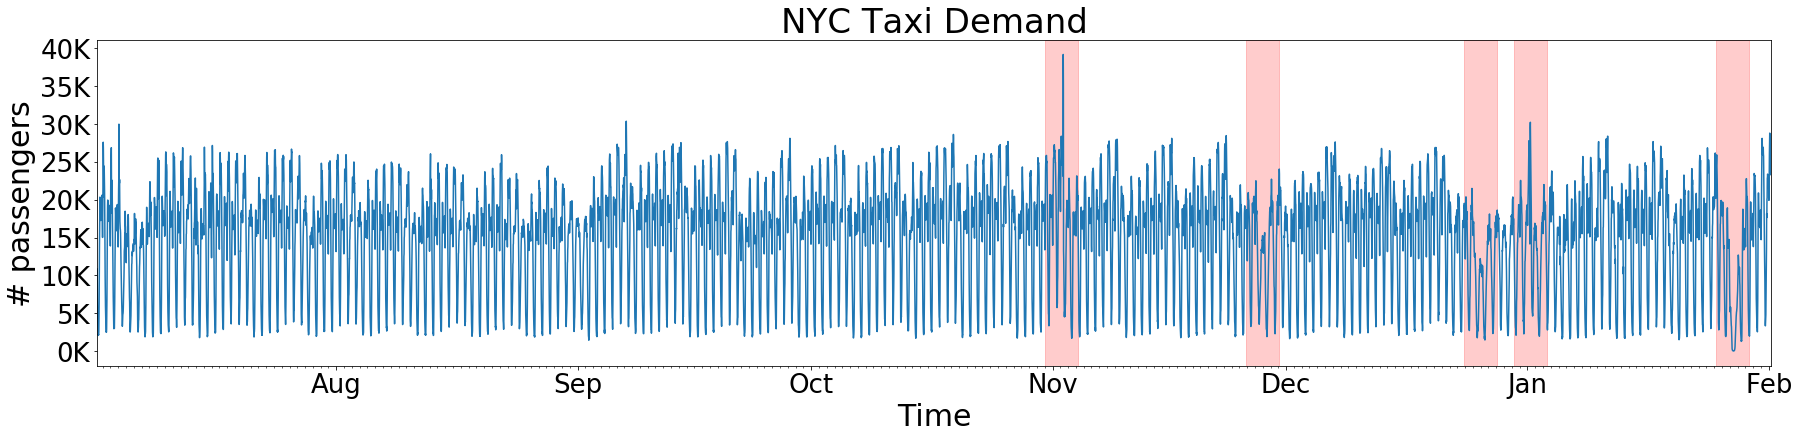

In [4]:
plot(df, known_anomalies)

* raw

In [27]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

X, index = time_segments_aggregate(df, interval=1800, time_column='timestamp')

* imputation

In [28]:
imp = SimpleImputer()
X = imp.fit_transform(X)

* scaling

In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [31]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

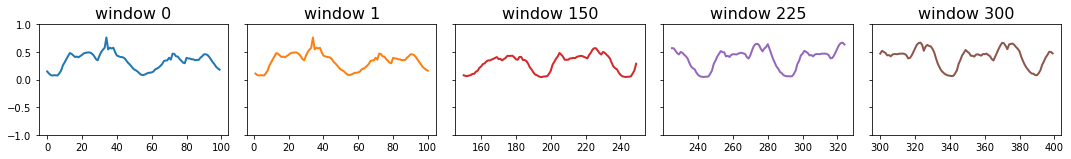

In [33]:
plot_rws(X)

## Anomaly Gap Maximize TadGAN

In [84]:
import logging
import math
import tempfile
from functools import partial

import keras
import numpy as np
import pandas as pd
from keras import backend as K
from keras.layers import Input
from keras.layers.merge import _Merge
from keras.models import Model
from mlprimitives.adapters.keras import build_layer
from mlprimitives.utils import import_object
from scipy import stats

from orion.primitives.timeseries_errors import reconstruction_errors

class RandomWeightedAverage(_Merge):
    def _merge_function(self, inputs):
        """
        Args:
            inputs[0] x     original input
            inputs[1] x_    predicted input
        """
        alpha = K.random_uniform((64, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])


class TadGAN_agm(object):

    def __getstate__(self):
        networks = ['critic_x', 'critic_z', 'encoder', 'generator']
        modules = ['optimizer', 'critic_x_model', 'critic_z_model', 'encoder_generator_model']

        state = self.__dict__.copy()

        for module in modules:
            del state[module]

        for network in networks:
            with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=False) as fd:
                keras.models.save_model(state.pop(network), fd.name, overwrite=True)

                state[network + '_str'] = fd.read()

        return state

    def __setstate__(self, state):
        networks = ['critic_x', 'critic_z', 'encoder', 'generator']
        for network in networks:
            with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=False) as fd:
                fd.write(state.pop(network + '_str'))
                fd.flush()

                state[network] = keras.models.load_model(fd.name)

        self.__dict__ = state

    def _build_model(self, hyperparameters, layers, input_shape):
        x = Input(shape=input_shape)
        model = keras.models.Sequential()

        for layer in layers:
            built_layer = build_layer(layer, hyperparameters)
            model.add(built_layer)

        return Model(x, model(x))

    def _wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def _gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        gradients = K.gradients(y_pred, averaged_samples)[0]
        gradients_sqr = K.square(gradients)
        gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        gradient_penalty = K.square(1 - gradient_l2_norm)
        return K.mean(gradient_penalty)

    def __init__(self, shape, encoder_input_shape, generator_input_shape, critic_x_input_shape,
                 critic_z_input_shape, layers_encoder, layers_generator, layers_critic_x,
                 layers_critic_z, optimizer, learning_rate=0.0005, epochs=2000, latent_dim=20,
                 batch_size=64, iterations_critic=5, **hyperparameters):

        self.shape = shape
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.iterations_critic = iterations_critic
        self.epochs = epochs
        self.hyperparameters = hyperparameters

        self.encoder_input_shape = encoder_input_shape
        self.generator_input_shape = generator_input_shape
        self.critic_x_input_shape = critic_x_input_shape
        self.critic_z_input_shape = critic_z_input_shape

        self.layers_encoder, self.layers_generator = layers_encoder, layers_generator
        self.layers_critic_x, self.layers_critic_z = layers_critic_x, layers_critic_z

        self.optimizer = import_object(optimizer)(learning_rate)
        self.pg_advantage = 1
    
    def pg_loss(self, y_true, y_pred) :
            log_probability = tf.math.log(y_pred + 1e-6)
            agm_loss = -tf.reduce_mean(log_probability * self.pg_advantage)

            return agm_loss
    
    def _build_tadgan(self, **kwargs):

        hyperparameters = self.hyperparameters.copy()
        hyperparameters.update(kwargs)

        self.encoder = self._build_model(hyperparameters, self.layers_encoder,
                                         self.encoder_input_shape)
        self.generator = self._build_model(hyperparameters, self.layers_generator,
                                           self.generator_input_shape)
        self.critic_x = self._build_model(hyperparameters, self.layers_critic_x,
                                          self.critic_x_input_shape)
        self.critic_z = self._build_model(hyperparameters, self.layers_critic_z,
                                          self.critic_z_input_shape)

        self.generator.trainable = False
        self.encoder.trainable = False

        z = Input(shape=(self.latent_dim, 1))
        x = Input(shape=self.shape)
        x_ = self.generator(z)
        z_ = self.encoder(x)
        fake_x = self.critic_x(x_)
        valid_x = self.critic_x(x)
        interpolated_x = RandomWeightedAverage()([x, x_])
        validity_interpolated_x = self.critic_x(interpolated_x)
        partial_gp_loss_x = partial(self._gradient_penalty_loss, averaged_samples=interpolated_x)
        partial_gp_loss_x.__name__ = 'gradient_penalty'
        self.critic_x_model = Model(inputs=[x, z], outputs=[valid_x, fake_x,
                                                            validity_interpolated_x])
        self.critic_x_model.compile(loss=[self._wasserstein_loss, self._wasserstein_loss,
                                          partial_gp_loss_x], optimizer=self.optimizer,
                                    loss_weights=[1, 1, 10])

        fake_z = self.critic_z(z_)
        valid_z = self.critic_z(z)
        interpolated_z = RandomWeightedAverage()([z, z_])
        validity_interpolated_z = self.critic_z(interpolated_z)
        partial_gp_loss_z = partial(self._gradient_penalty_loss, averaged_samples=interpolated_z)
        partial_gp_loss_z.__name__ = 'gradient_penalty'
        self.critic_z_model = Model(inputs=[x, z], outputs=[valid_z, fake_z,
                                                            validity_interpolated_z])
        self.critic_z_model.compile(loss=[self._wasserstein_loss, self._wasserstein_loss,
                                          partial_gp_loss_z], optimizer=self.optimizer,
                                    loss_weights=[1, 1, 10])

        self.critic_x.trainable = False
        self.critic_z.trainable = False
        self.generator.trainable = True
        self.encoder.trainable = True

        z_gen = Input(shape=(self.latent_dim, 1))
        x_gen_ = self.generator(z_gen)
        x_gen = Input(shape=self.shape)
        z_gen_ = self.encoder(x_gen)
        x_gen_rec = self.generator(z_gen_)
        fake_gen_x = self.critic_x(x_gen_)
        fake_gen_z = self.critic_z(z_gen_)

        #self.encoder_generator_model = Model([x_gen, z_gen], [fake_gen_x, fake_gen_z, x_gen_rec])
        self.encoder_generator_model = Model([x_gen, z_gen], [fake_gen_x, fake_gen_z, x_gen_rec, x_gen_rec])
        self.encoder_generator_model.compile(loss=[self._wasserstein_loss, self._wasserstein_loss, 'mse', self.pg_loss],
                                             optimizer=self.optimizer,
                                             loss_weights=[1, 1, 10, 1])
    
    
    def _fit(self, X):
        fake = np.ones((self.batch_size, 1))
        valid = -np.ones((self.batch_size, 1))
        delta = np.ones((self.batch_size, 1))

        X_ = np.copy(X)
        for epoch in range(1, self.epochs + 1):
            np.random.shuffle(X_)
            epoch_g_loss = []
            epoch_cx_loss = []
            epoch_cz_loss = []

            minibatches_size = self.batch_size * self.iterations_critic
            num_minibatches = int(X_.shape[0] // minibatches_size)

            for i in range(num_minibatches):
                minibatch = X_[i * minibatches_size: (i + 1) * minibatches_size]

                for j in range(self.iterations_critic):
                    x = minibatch[j * self.batch_size: (j + 1) * self.batch_size]
                    z = np.random.normal(size=(self.batch_size, self.latent_dim, 1))
                    
                    epoch_cx_loss.append(
                        self.critic_x_model.train_on_batch([x, z], [valid, fake, delta]))
                    epoch_cz_loss.append(
                        self.critic_z_model.train_on_batch([x, z], [valid, fake, delta]))
                
                ### Anomaly Gap Maximize loss ###
                ## latent vector -> real
                z_ = self.encoder.predict(x)
                ## noise -> fake (z)
                
                ## reconstructed values
                x_hat_real = self.generator.predict(z_)
                x_hat_fake = self.generator.predict(z)

                ## reconstruction error
                real_recon = K.constant(x-x_hat_real)
                fake_recon = K.constant(x-x_hat_fake)

                ## get pg_advantage
                self.pg_advantage = tf.stop_gradient(K.mean((fake_recon)**2)-K.mean((real_recon)**2))
                self.pg_advantage = K.get_value(self.pg_advantage)
                
                epoch_g_loss.append(
                    self.encoder_generator_model.train_on_batch([x, z], [valid, valid, x, x]))

            cx_loss = np.mean(np.array(epoch_cx_loss), axis=0)
            cz_loss = np.mean(np.array(epoch_cz_loss), axis=0)
            g_loss = np.mean(np.array(epoch_g_loss), axis=0)
            print('Epoch: {}/{}, [Dx loss: {}] [Dz loss: {}] [G loss: {}]'.format(
                epoch, self.epochs, cx_loss, cz_loss, g_loss))

    def fit(self, X, **kwargs):
        """Fit the TadGAN.

        Args:
            X (ndarray):
                N-dimensional array containing the input training sequences for the model.
        """
        self._build_tadgan(**kwargs)
        X = X.reshape((-1, self.shape[0], 1))
        self._fit(X)

    def predict(self, X):
        """Predict values using the initialized object.

        Args:
            X (ndarray):
                N-dimensional array containing the input sequences for the model.

        Returns:
            ndarray:
                N-dimensional array containing the reconstructions for each input sequence.
            ndarray:
                N-dimensional array containing the critic scores for each input sequence.
        """

        X = X.reshape((-1, self.shape[0], 1))
        z_ = self.encoder.predict(X)
        y_hat = self.generator.predict(z_)
        critic = self.critic_x.predict(X)

        return y_hat, critic

In [85]:
hyperparameters["epochs"] = 100
hyperparameters["shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

In [86]:
tadgan_agm = TadGAN_agm(**hyperparameters)

In [ ]:
tadgan_agm.fit(X)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# flatten the predicted windows
y_hat = unroll_ts(X_hat)

# plot the time series
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

In [ ]:
# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()

In [ ]:
from orion.primitives.tadgan import score_anomalies

error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)

# visualize the error curve
plot_error([[true, pred], error])

In [ ]:
# threshold
thresh = 10

intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while error[i] > thresh:
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

In [ ]:
import pandas as pd
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

In [49]:
import tensorflow as tf

In [82]:
## latent vector -> real
z_ = self.encoder.predict(X)
## noise -> fake
#z = np.random.normal(size=(10222, 20, 1))

## reconstructed values
X_hat_real = self.generator.predict(z_)
X_hat_fake = self.generator.predict(z)

## reconstruction error
real_recon = K.constant(X-X_hat_real)
fake_recon = K.constant(X-X_hat_fake)

## get pg_advantage
self.pg_advantage = tf.stop_gradient(K.mean((fake_recon)**2)-K.mean((real_recon)**2))
self.pg_advantage = K.get_value(self.pg_advantage)

def pg_loss(self, y_true, y_pred) :
    policy_gradient_cce = tf.math.log(y_pred + 1e-6)
    ridge_maximize_loss = -tf.reduce_mean(policy_gradient_cce * self.pg_advantage)

    return ridge_maximize_loss

* 참고: https://ichi.pro/ko/sigyeyeol-isang-tamji-dib-leoning-sidae-264035144704586